## Home Prices Report

This notebook analyzes home price data.

In [109]:
import datetime
from dateutil.relativedelta import relativedelta
from pyfredapi import FredSeries
from rich import print as rprint
import pandas as pd
import plotly.express as px
from utils.state_abb import state_abb
from utils.pandas_utils import get_dates, calc_pct_chg, display_pct_chg_df
from utils.pyfredapi import SeriesCollection
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from rich import print as rprint

In [2]:
state_home_price_index_series = [f"{abb}STHPI" for abb in state_abb.values()]

case_shiller_series = [
    "CSUSHPISA",
    "SPCS20RSA",
    "SFXRSA",
    "LXXRSA",
    "SDXRSA",
    "NYXRSA",
    "CHXRSA",
    "SEXRSA",
    "BOXRSA",
    "PHXRSA",
    "MIXRSA",
    "DNXRSA",
    "DAXRSA",
    "WDXRSA",
    "ATXRSA",
    "LVXRSA",
    "POXRSA",
    "TPXRSA",
    "CRXRSA",
    "MNXRSA",
    "DEXRSA",
    "CEXRSA",
]

housing_starts_series = ["HOUST", "HOUST1F", "HOUST2F", "HOUST5F"]
housing_sale_price_series = ["MSPUS", "MSPNHSUS"]
house_supply_series = ["MSACSRNSA"]
mortgage_rate_series = ["MORTGAGE30US", "MORTGAGE15US"]
bond_yield_series = ["WGS10YR", "WGS20YR", "WGS30YR"]
fed_mbs_series = ["WSHOMCB"]
home_ownership_rates_series = ["RHORUSQ156N"]
median_hh_income_series = ["MEHOINUSA672N"]
mortgage_debt_as_perc_of_income_series = ["MDSP"]
fund_funds_rate = ["FEDFUNDS"]

# Calculate the spread on the 30-year mortgage and the 10-year yield

In [ ]:
client = FredSeries()

In [ ]:
home_sale_price_sc = SeriesCollection(client)
home_sale_price_sc.add_series(series=state_home_price_index_series)

In [ ]:
case_shiller_sc = SeriesCollection(client=client, series=case_shiller_series)

In [ ]:
housing_starts_series_sc = SeriesCollection(client=client, series=housing_starts_series)

In [4]:
rates_sc = SeriesCollection()
rates_sc.add_series(series=fund_funds_rate + mortgage_rate_series + bond_yield_series)

Requesting series FEDFUNDS...
Requesting series MORTGAGE30US...
Requesting series MORTGAGE15US...
Requesting series WGS10YR...
Requesting series WGS20YR...
Requesting series WGS30YR...


In [5]:
rates_sc.list_series()

FEDFUNDS: Federal Funds Effective Rate

MORTGAGE30US: 30-Year Fixed Rate Mortgage Average in the United States

MORTGAGE15US: 15-Year Fixed Rate Mortgage Average in the United States

WGS10YR: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis

WGS20YR: Market Yield on U.S. Treasury Securities at 20-Year Constant Maturity, Quoted on an Investment Basis

WGS30YR: Market Yield on U.S. Treasury Securities at 30-Year Constant Maturity, Quoted on an Investment Basis

In [ ]:
rates_sc.show_seasonality()

In [ ]:
rates_sc.show_frequency()

In [ ]:
rates_sc.show_observation_end()

## Compare 30-year mortgage rate, 10-year treasury rate, and federal funds rate

In [36]:
mort_15year = rates_sc.MORTGAGE15US.data.copy()
mort_30year = rates_sc.MORTGAGE30US.data.copy()
tres_10year = rates_sc.WGS10YR.data.copy()
mort_30year = rates_sc.MORTGAGE30US.data.copy()
fed_funds_rate = rates_sc.FEDFUNDS.data.copy()

In [ ]:
rates_sc.responses

In [37]:
df = pd.merge_asof(
    left=tres_10year,
    right=mort_30year,
    on="date"
)

df = pd.merge_asof(
    left=df,
    right=mort_15year,
    on="date"
)

In [39]:
df["spread_10vs30"] = df["MORTGAGE30US"] - df["WGS10YR"]
df["spread_10vs15"] = df["MORTGAGE15US"] - df["WGS10YR"]

In [18]:
rates_sc.WGS10YR.info.title

'Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis'

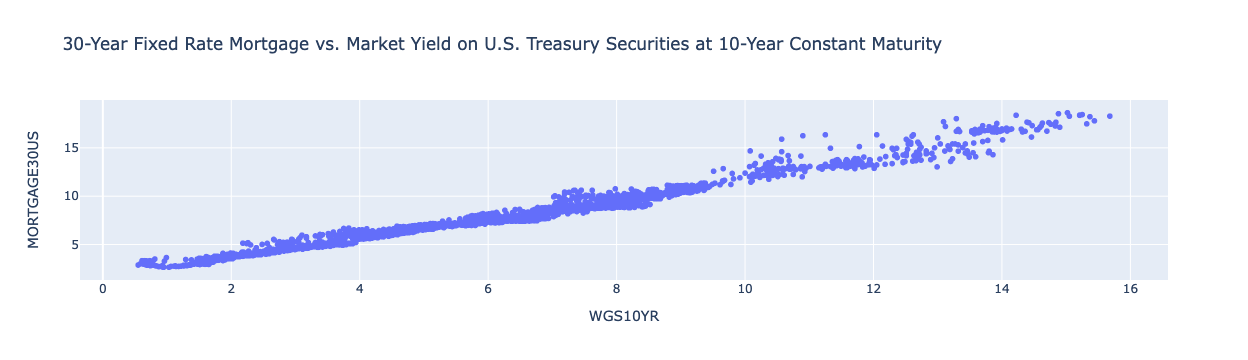

In [40]:
fig = px.scatter(
    df,
    x="WGS10YR",
    y="MORTGAGE30US",
    title="30-Year Fixed Rate Mortgage vs. Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity",
    hover_data={"date": True},
)
# fig.layout.yaxis.tickformat = ",.0%"
# fig.layout.xaxis.tickformat = ",.0%"

fig.show()

In [108]:
model_df = df.dropna()

y = model_df["MORTGAGE15US"]
X = model_df["WGS10YR"]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE15US   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.963
Method:                 Least Squares   F-statistic:                 4.241e+04
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:41:39   Log-Likelihood:                -610.92
No. Observations:                1624   AIC:                             1226.
Df Residuals:                    1622   BIC:                             1237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2222      0.021     57.830      0.0

In [111]:
model_df = df.dropna()

y = model_df["MORTGAGE30US"]
X = model_df["WGS10YR"]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           MORTGAGE30US   R-squared:                       0.973
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                 5.911e+04
Date:                Sat, 15 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:42:36   Log-Likelihood:                -248.95
No. Observations:                1624   AIC:                             501.9
Df Residuals:                    1622   BIC:                             512.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9957      0.017    118.012      0.0

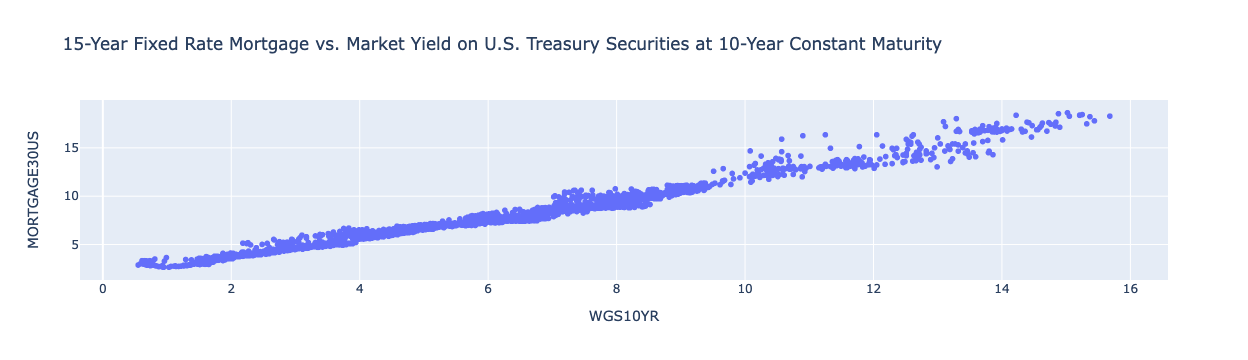

In [112]:
fig = px.scatter(
    df,
    x="WGS10YR",
    y="MORTGAGE30US",
    title="15-Year Fixed Rate Mortgage vs. Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity",
    hover_data={"date": True},
)
# fig.layout.yaxis.tickformat = ",.0%"
# fig.layout.xaxis.tickformat = ",.0%"

fig.show()

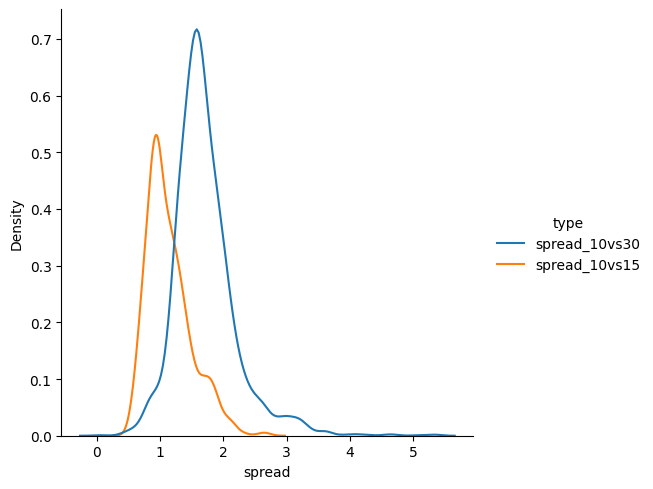

In [89]:
df1 = df[["date", "spread_10vs30"]]
df1 = df1.rename(columns={"spread_10vs30": "spread"})
df1["type"] = "spread_10vs30"

df2 = df[["date", "spread_10vs15"]]
df2 = df2.rename(columns={"spread_10vs15": "spread"})
df2["type"] = "spread_10vs15"

plt_df = pd.concat(
    [df1, df2],
    axis=0
).reset_index()


sns.displot(data=plt_df, x="spread", hue="type", kind="kde")

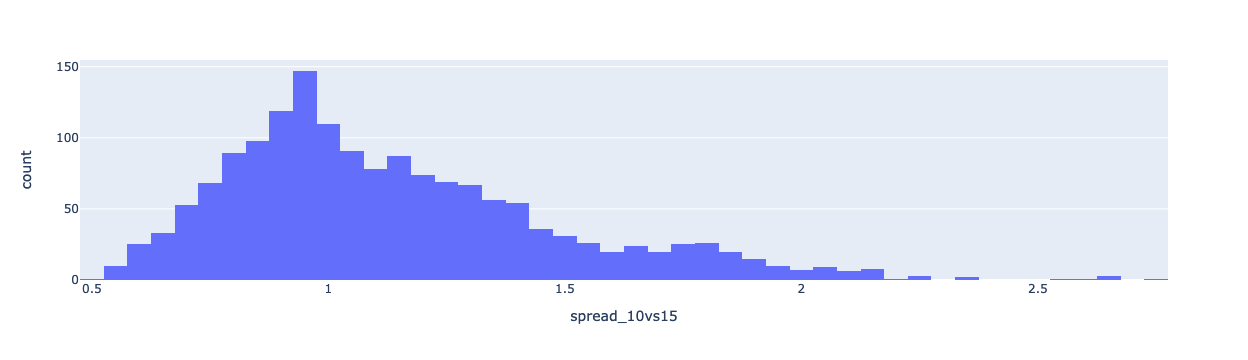

In [88]:
px.histogram(df, x="spread_10vs15")

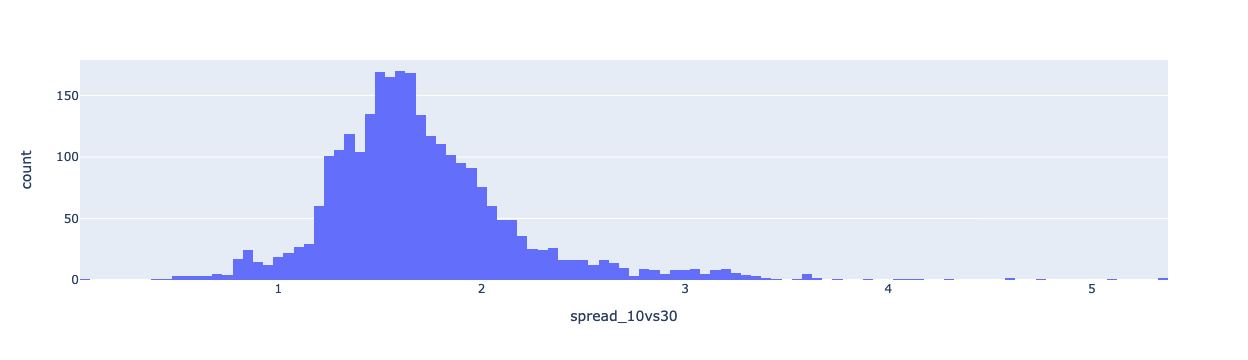

In [42]:
px.histogram(df, x="spread_10vs30")

In [ ]:
home_sale_price_response = {s: client.get_series(s) for s in housing_starts_series}

In [ ]:
home_sale_price_response["HOUST"].info.units

In [ ]:
home_sale_price_response["HOUST"].data

In [ ]:
housing_sale_price_series_response = {
    s: client.get_series(s) for s in housing_sale_price_series
}

In [ ]:
housing_sale_price_series_response["MSPUS"].info.title

In [ ]:
mortgage_rate_series_responses = {s: client.get_series(s) for s in mortgage_rate_series}

In [ ]:
mortgage_rate_series_responses["MORTGAGE30US"].data.dtypes

## Collect home price data

# Median Sale Price

# Housing Starts

In [ ]:
housing_starts_response = {s: client.get_series(s) for s in housing_starts_series}

# State House Price Index

In [ ]:
state_hp_responses = {s: client.get_series(s) for s in state_home_price_index_series}

### Munge the data

In [ ]:
state_hp_dfs = []
state_hp_wide_dfs = []

for s in state_home_price_index_series:
    state_name = state_hp_responses[s].info.title.replace(
        "All-Transactions House Price Index for ", ""
    )

    df = (
        state_hp_responses[s]
        .data.drop(["realtime_start", "realtime_end"], axis=1)
        .copy()
    )
    df["state"] = state_name
    state_hp_dfs.append(df)

    wide_df = (
        state_hp_responses[s]
        .data.drop(["realtime_start", "realtime_end"], axis=1)
        .copy()
    )
    wide_df = wide_df.rename(columns={"value": state_name}).set_index("date")
    state_hp_wide_dfs.append(wide_df)

state_hp_df = pd.concat(state_hp_dfs, axis=0)
state_hp_wide_df = pd.concat(state_hp_wide_dfs, axis=1)

In [ ]:
state_hp_dates = get_dates(state_hp_df, "date")
rprint(f"Minimum home price date: {state_hp_dates.min}")
rprint(f"Maximum home price date: {state_hp_dates.max}")

### Percent Change Table

In [ ]:
state_hp_pct_chg_df = calc_pct_chg(
    wide_df=state_hp_wide_df.copy(),
    lags=[1, 4, 8],
    max_date=state_hp_dates.max,
    grp_var="State",
    lag_var="Quarters Ago",
    title="State Home Price Index Percent Change from Preceding Quarter",
)

# rprint(f"State Home Price Index Percent Change from Preceding Quarter, {state_hp_dates.max}")
display(state_hp_pct_chg_df)

### Plot

In [ ]:
line_plot = px.line(
    data_frame=state_hp_df,
    x="date",
    y="value",
    color="state",
    title=f"Quarterly Home Price Index by State (Index 1980:Q1=100)",
    labels=dict(value="Home Price Index", date="Date", state="State"),
)

line_plot.show(renderer="notebook")

# Case/Shiller Home Price Index

In [ ]:
cs_responses = {s: client.get_series(s) for s in case_shiller_series}

### Munge the data

In [ ]:
cs_dfs = []
cs_wide_dfs = []

for s in case_shiller_series:
    series_name = (
        cs_responses[s]
        .info.title.replace("S&P/Case-Shiller ", "")
        .replace(" Home Price Index", "")
    )

    df = cs_responses[s].data.drop(["realtime_start", "realtime_end"], axis=1).copy()

    df["series"] = series_name
    cs_dfs.append(df)

    wide_df = (
        cs_responses[s].data.drop(["realtime_start", "realtime_end"], axis=1).copy()
    )
    wide_df = wide_df.rename(columns={"value": series_name}).set_index("date")
    cs_wide_dfs.append(wide_df)

cs_df = pd.concat(cs_dfs)
cs_wide_df = pd.concat(cs_wide_dfs, axis=1)

In [ ]:
cs_dates = get_dates(cs_df, "date")
rprint(f"Minimum home price date: {cs_dates.min}")
rprint(f"Maximum home price date: {cs_dates.max}")

### Percent Change Table

In [ ]:
cs_pct_chg_df = calc_pct_chg(
    wide_df=cs_wide_df.copy().dropna(),
    lags=[1, 3, 6, 12, 18, 24, 36, 48, 60],
    max_date=cs_dates.max,
    grp_var="Series",
    lag_var="Months Ago",
    title="Case/Shiller Index Percent Change from Preceding Quarter",
)

display_pct_chg_df(
    df=cs_pct_chg_df.copy(),
    title="Seasonally Adjusted CPI, Percent Change from Preceding Month",
    max_date=dates.max,
)

display(cs_pct_chg_df)

### Plot

In [ ]:
line_plot = px.line(
    data_frame=cs_df.dropna(),
    x="date",
    y="value",
    color="series",
    title=f"Case/Shiller Home Price Index (Index Jan-2000=100)",
    labels=dict(value="CS Home Price Index", date="Date", series="Series"),
)

line_plot.show(renderer="notebook")